# Detecção de Fraude em Cartão de Crédito com SMOTE

Neste notebook, vamos construir um modelo de machine learning para detectar transações fraudulentas de cartão de crédito. O principal desafio deste conjunto de dados é o seu **grande desbalanceamento** entre as classes: a imensa maioria das transações são normais, e uma pequena minoria são fraudes.

**Objetivos:**
1. Analisar e visualizar os dados.
2. Pré-processar as features `Time` e `Amount`.
3. Lidar com o desbalanceamento dos dados usando a técnica de **SMOTE (Synthetic Minority Over-sampling Technique)**.
4. Treinar e comparar múltiplos modelos de classificação (Regressão Logística, Random Forest, XGBoost, LightGBM).
5. Avaliar a performance dos modelos.

## 1. Importando as Bibliotecas

In [1]:
import pandas as pd
import numpy as np
import seaborn as sns
import matplotlib.pyplot as plt
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import RobustScaler
from sklearn.linear_model import LogisticRegression
from sklearn.ensemble import RandomForestClassifier
from xgboost import XGBClassifier
from lightgbm import LGBMClassifier
from sklearn.metrics import classification_report, confusion_matrix, accuracy_score
from imblearn.over_sampling import SMOTE

%matplotlib inline

import warnings
warnings.filterwarnings("ignore")

## 2. Carregando os Dados

In [2]:
df = pd.read_csv('creditcard.csv')
df.head()

,Time,V1,V2,V3,V4,V5,V6,V7,V8,V9,...,V21,V22,V23,V24,V25,V26,V27,V28,Amount,Class
0,0.0,-1.359807,-0.072781,2.536347,1.378155,-0.338321,0.462388,0.239599,0.098698,0.363787,...,-0.018307,0.277838,-0.110474,0.066928,0.128539,-0.189115,0.133558,-0.021053,149.62,0
1,0.0,1.191857,0.266151,0.166480,0.448154,0.060018,-0.082361,-0.078803,0.085102,-0.255425,...,-0.225775,-0.638672,0.101288,-0.339846,0.167170,0.125895,-0.008983,0.014724,2.69,0
2,1.0,-1.358354,-1.340163,1.773209,0.379780,-0.503198,1.800499,0.791461,0.247676,-1.514654,...,0.247998,0.771679,0.909412,-0.689281,-0.327642,-0.139097,-0.055353,-0.059752,378.66,0
3,1.0,-0.966272,-0.185226,1.792993,-0.863291,-0.010309,1.247203,0.237609,0.377436,-1.387024,...,-0.108300,0.005274,-0.190321,-1.175575,0.647376,-0.221929,0.062723,0.061458,123.50,0
4,2.0,-1.158233,0.877737,1.548718,0.403034,-0.407193,0.095921,0.592941,-0.270533,0.817739,...,-0.009431,0.798278,-0.137458,0.141267,-0.206010,0.502292,0.219422,0.215153,69.99,0


## 3. Análise Exploratória e Pré-Processamento

Primeiro, vamos verificar a distribuição das classes. Como podemos ver, o dataset é extremamente desbalanceado.

Distribuição das Classes:
Class
0    284315
1       492
Name: count, dtype: int64
Fraudes representam 0.17% do dataset.


Text(0.5, 1.0, 'Distribuição das Classes (0: Não-Fraude || 1: Fraude)')

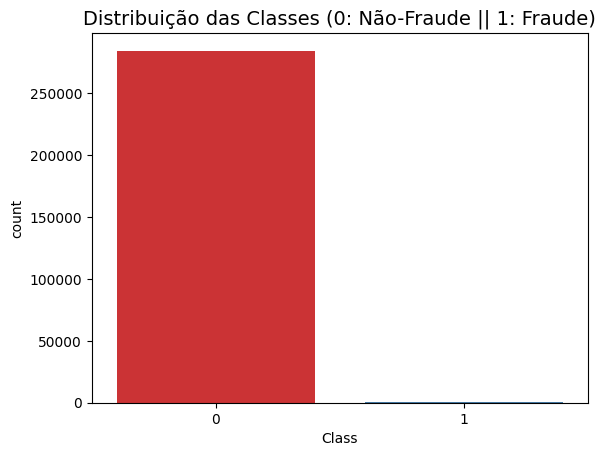

In [3]:
print('Distribuição das Classes:')
print(df['Class'].value_counts())
print('Fraudes representam {:.2f}% do dataset.'.format(df[df['Class'] == 1].shape[0] / df.shape[0] * 100))

sns.countplot(x='Class', data=df, palette='Set1')
plt.title('Distribuição das Classes (0: Não-Fraude || 1: Fraude)', fontsize=14)

As features `V1` a `V28` já foram anonimizadas e escalonadas (através de PCA). No entanto, as colunas `Time` e `Amount` não foram. Vamos escaloná-las para que tenham a mesma escala das outras features, o que é importante para o bom desempenho de muitos algoritmos de machine learning.

Usaremos o `RobustScaler`, que é menos sensível a outliers.

In [4]:
rob_scaler = RobustScaler()

df['scaled_amount'] = rob_scaler.fit_transform(df['Amount'].values.reshape(-1,1))
df['scaled_time'] = rob_scaler.fit_transform(df['Time'].values.reshape(-1,1))

df.drop(['Time','Amount'], axis=1, inplace=True)

# Reorganizando as colunas
scaled_amount = df['scaled_amount']
scaled_time = df['scaled_time']
df.drop(['scaled_amount', 'scaled_time'], axis=1, inplace=True)
df.insert(0, 'scaled_amount', scaled_amount)
df.insert(1, 'scaled_time', scaled_time)

df.head()

,scaled_amount,scaled_time,V1,V2,V3,V4,V5,V6,V7,V8,...,V20,V21,V22,V23,V24,V25,V26,V27,V28,Class
0,1.783274,-0.994983,-1.359807,-0.072781,2.536347,1.378155,-0.338321,0.462388,0.239599,0.098698,...,0.251412,-0.018307,0.277838,-0.110474,0.066928,0.128539,-0.189115,0.133558,-0.021053,0
1,-0.269825,-0.994983,1.191857,0.266151,0.166480,0.448154,0.060018,-0.082361,-0.078803,0.085102,...,-0.069083,-0.225775,-0.638672,0.101288,-0.339846,0.167170,0.125895,-0.008983,0.014724,0
2,4.983721,-0.994972,-1.358354,-1.340163,1.773209,0.379780,-0.503198,1.800499,0.791461,0.247676,...,0.524980,0.247998,0.771679,0.909412,-0.689281,-0.327642,-0.139097,-0.055353,-0.059752,0
3,1.418291,-0.994972,-0.966272,-0.185226,1.792993,-0.863291,-0.010309,1.247203,0.237609,0.377436,...,-0.208038,-0.108300,0.005274,-0.190321,-1.175575,0.647376,-0.221929,0.062723,0.061458,0
4,0.670579,-0.994960,-1.158233,0.877737,1.548718,0.403034,-0.407193,0.095921,0.592941,-0.270533,...,0.408542,-0.009431,0.798278,-0.137458,0.141267,-0.206010,0.502292,0.219422,0.215153,0


## 4. Balanceamento dos Dados (SMOTE)

Para corrigir o desbalanceamento, vamos usar a técnica **SMOTE (Synthetic Minority Over-sampling Technique)**. O SMOTE funciona criando novas amostras sintéticas da classe minoritária (fraude) com base nas amostras existentes, em vez de remover amostras da classe majoritária. Isso ajuda a balancear o dataset sem perda de informação.

Distribuição das classes no dataset balanceado (SMOTE):
Class
0    227451
1    227451
Name: count, dtype: int64


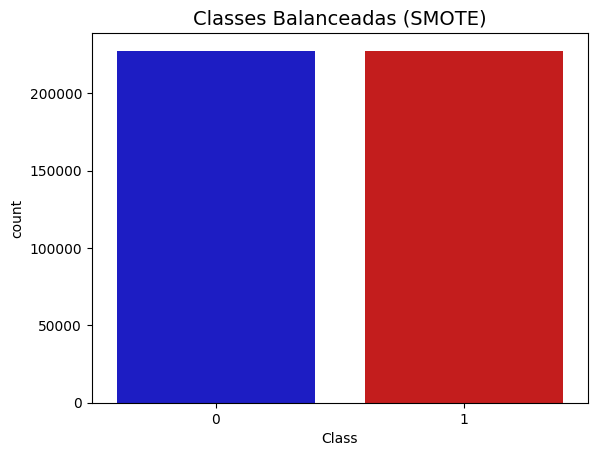

In [5]:
# Separando o dataframe original em treino e teste
X = df.drop('Class', axis=1)
y = df['Class']
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42, stratify=y)

# Aplicando SMOTE apenas nos dados de treino
sm = SMOTE(random_state=42)
X_train_smote, y_train_smote = sm.fit_resample(X_train, y_train)

print('Distribuição das classes no dataset balanceado (SMOTE):')
print(y_train_smote.value_counts())

sns.countplot(x=y_train_smote, palette=['#0101DF', '#DF0101'])
plt.title('Classes Balanceadas (SMOTE)', fontsize=14);

## 5. Matriz de Correlação

Agora com os dados balanceados, podemos analisar a matriz de correlação para entender quais features estão mais relacionadas com a ocorrência de fraudes.

Text(0.5, 1.0, 'Matriz de Correlação - Dados Balanceados (SMOTE)')

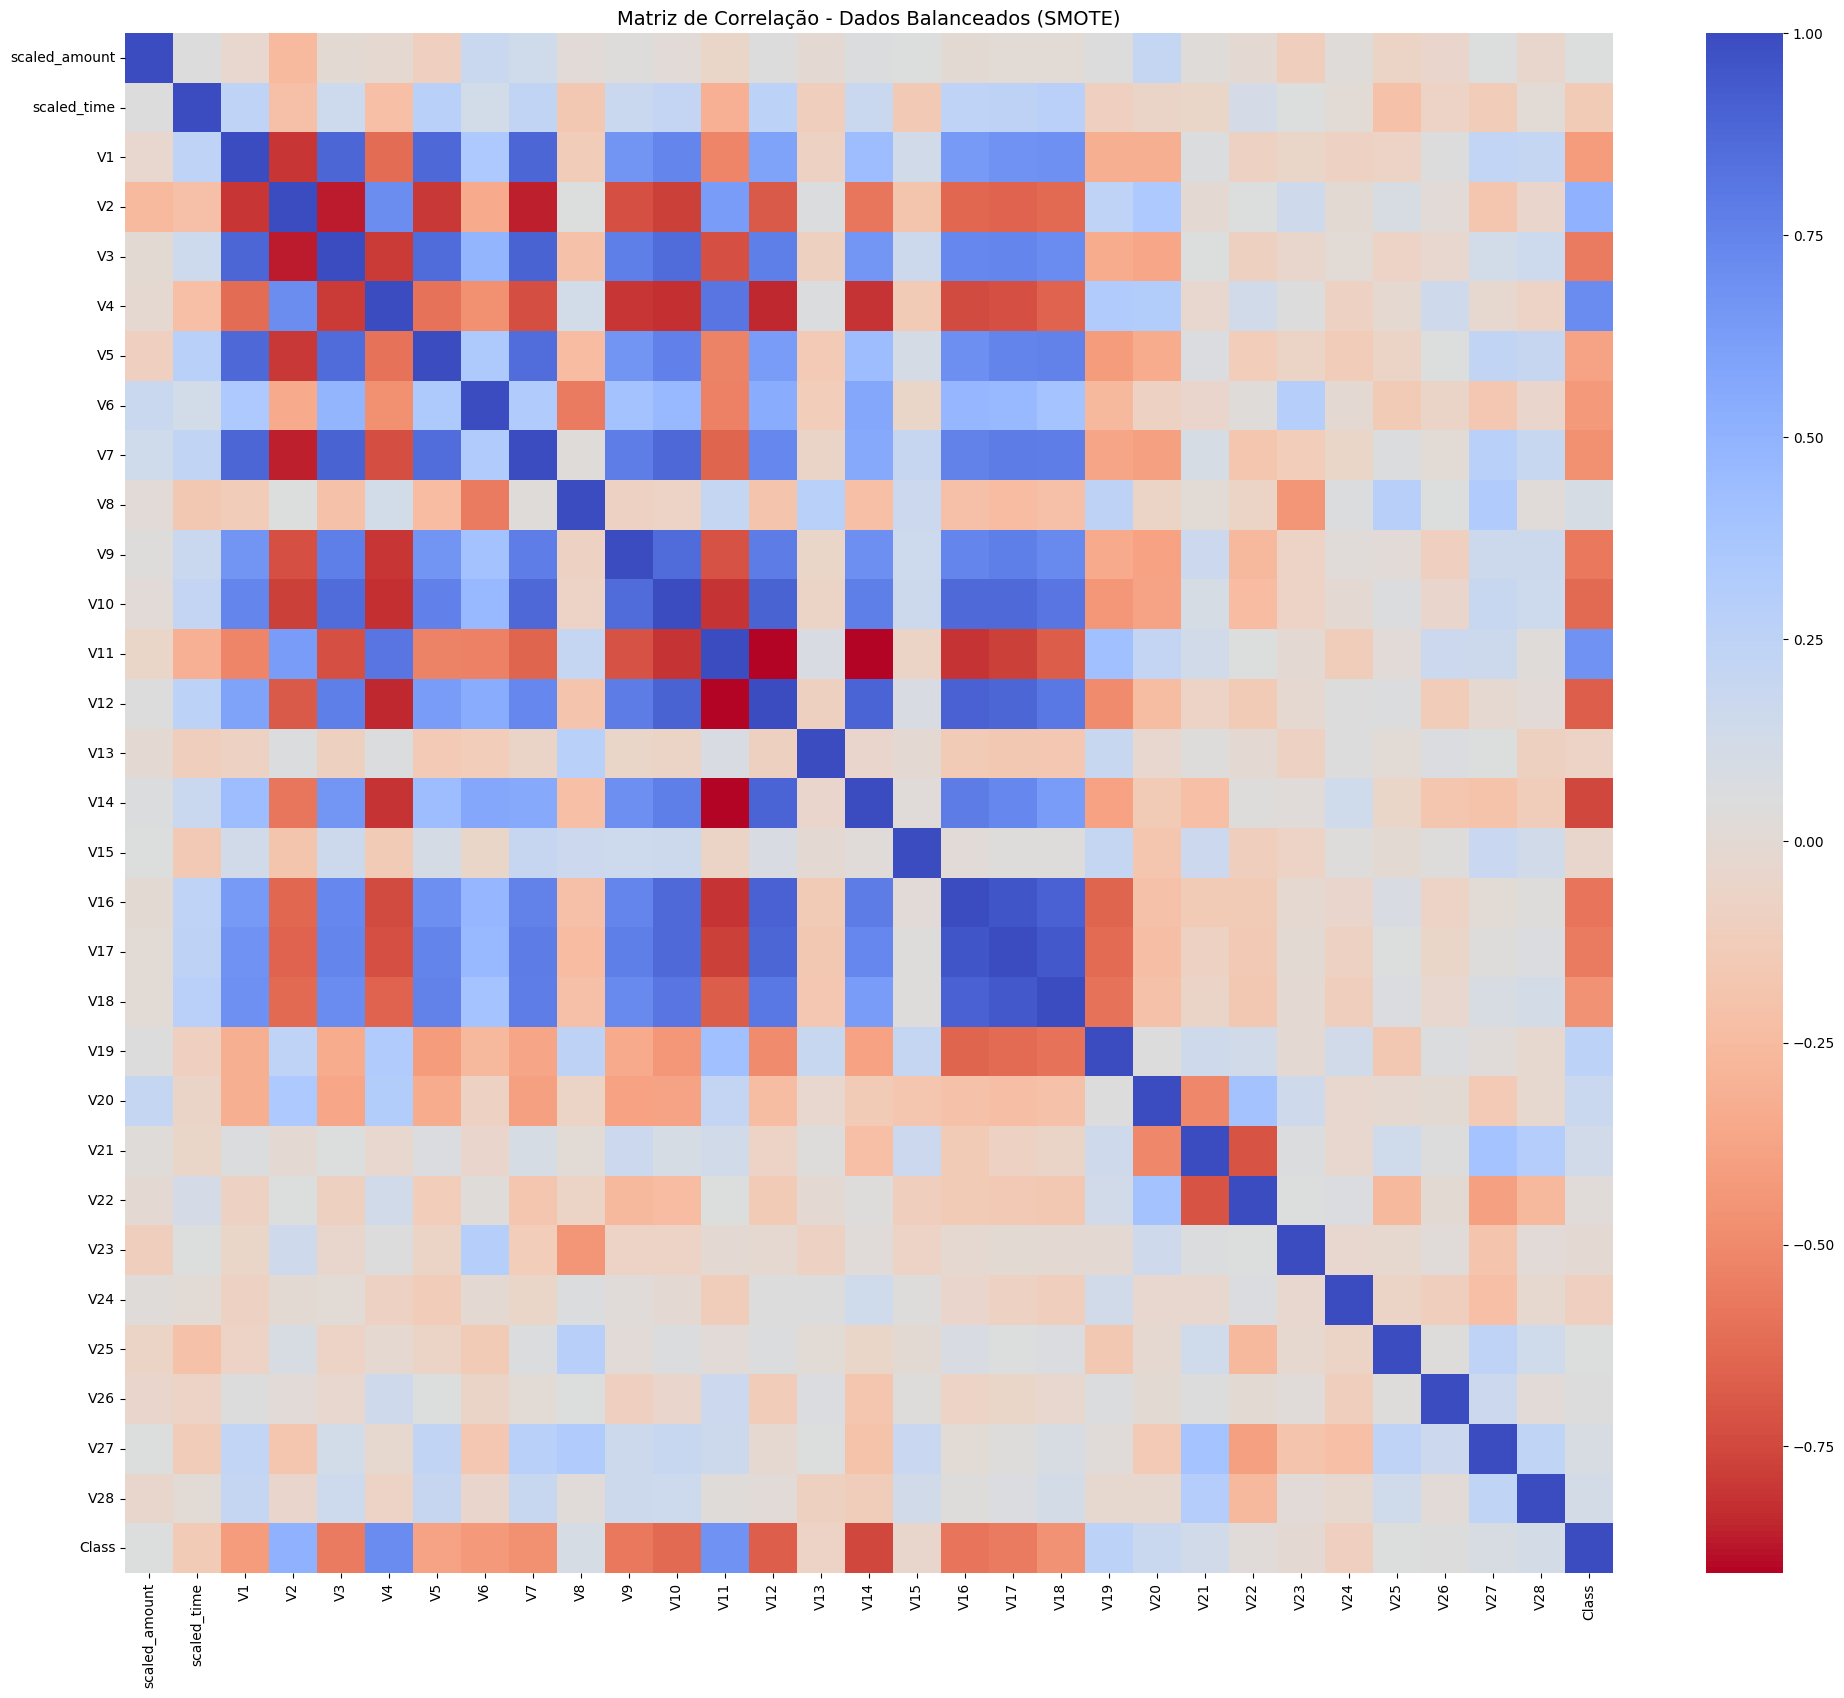

In [6]:
# Criando um dataframe temporário para a matriz de correlação com os dados SMOTE
balanced_df_smote = pd.concat([X_train_smote, y_train_smote], axis=1)
corr = balanced_df_smote.corr()
plt.figure(figsize=(24, 20))
sns.heatmap(corr, cmap='coolwarm_r', annot_kws={'size':20})
plt.title('Matriz de Correlação - Dados Balanceados (SMOTE)', fontsize=14)

## 6. Treinamento e Avaliação dos Modelos

Agora, vamos treinar e avaliar múltiplos modelos. Para cada um, faremos o seguinte:
1. Treinar o modelo com os dados de treino balanceados (`X_train_smote`, `y_train_smote`).
2. Avaliar o desempenho no conjunto de teste original e desbalanceado (`X_test`, `y_test`).

Isso nos dará uma visão realista de como cada modelo se comportaria em um cenário real.

### Modelos a serem testados:
- Regressão Logística
- Random Forest
- XGBoost
- LightGBM

--- Treinando e Avaliando: Regressão Logística ---


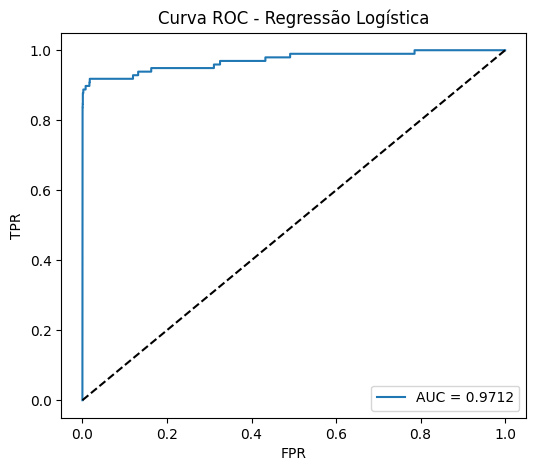

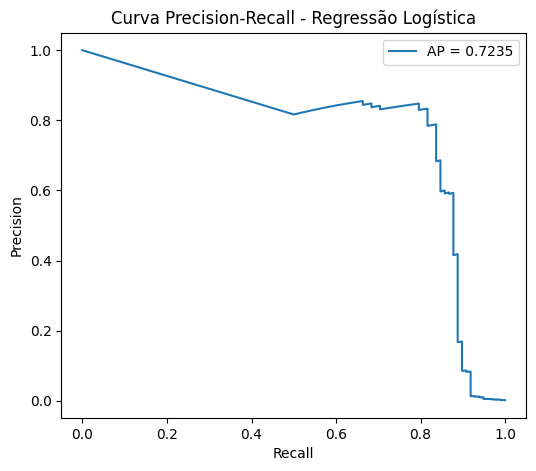

Acurácia: 0.9747
Relatório de Classificação:
              precision    recall  f1-score   support

           0       1.00      0.97      0.99     56864
           1       0.06      0.92      0.11        98

    accuracy                           0.97     56962
   macro avg       0.53      0.95      0.55     56962
weighted avg       1.00      0.97      0.99     56962



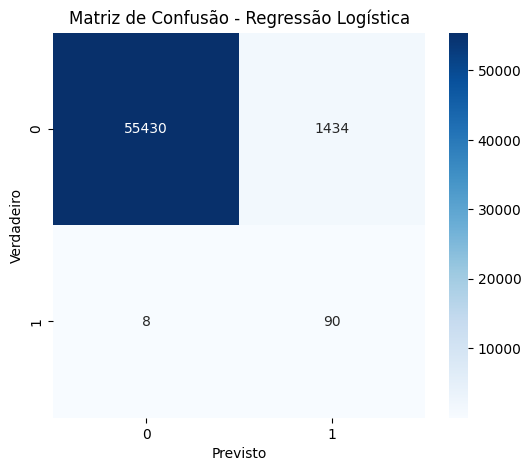

--- Treinando e Avaliando: XGBoost ---


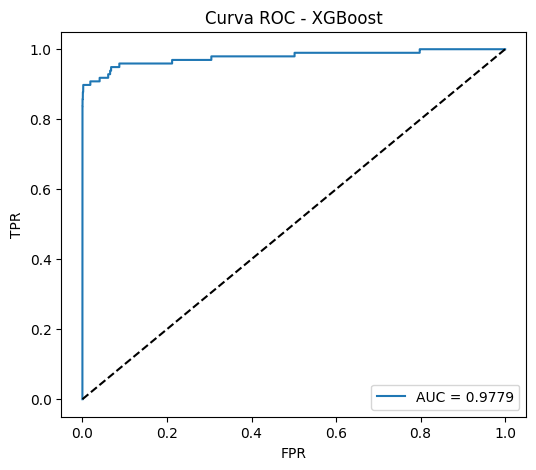

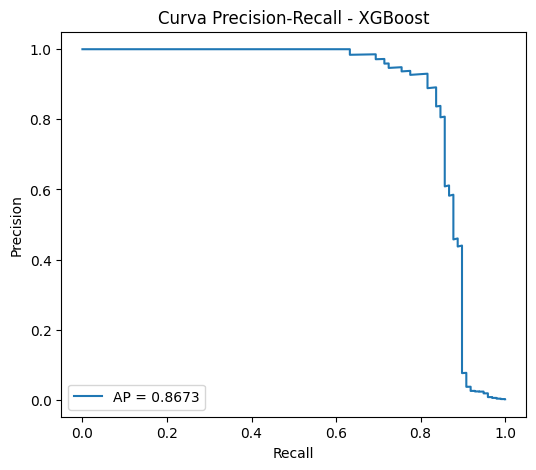

Acurácia: 0.9992
Relatório de Classificação:
              precision    recall  f1-score   support

           0       1.00      1.00      1.00     56864
           1       0.72      0.86      0.78        98

    accuracy                           1.00     56962
   macro avg       0.86      0.93      0.89     56962
weighted avg       1.00      1.00      1.00     56962



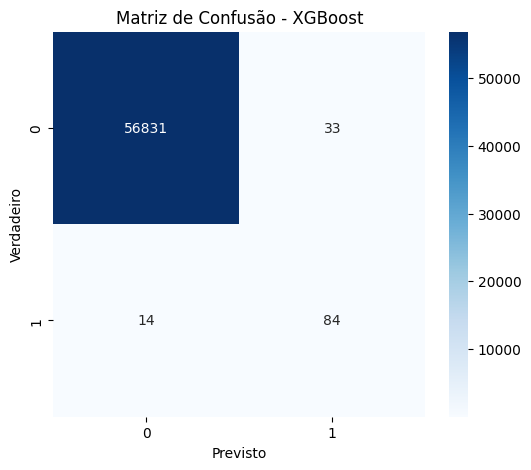

--- Treinando e Avaliando: LightGBM ---
[LightGBM] [Info] Number of positive: 227451, number of negative: 227451
[LightGBM] [Info] Auto-choosing col-wise multi-threading, the overhead of testing was 0.023334 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 7650
[LightGBM] [Info] Number of data points in the train set: 454902, number of used features: 30
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.500000 -> initscore=0.000000


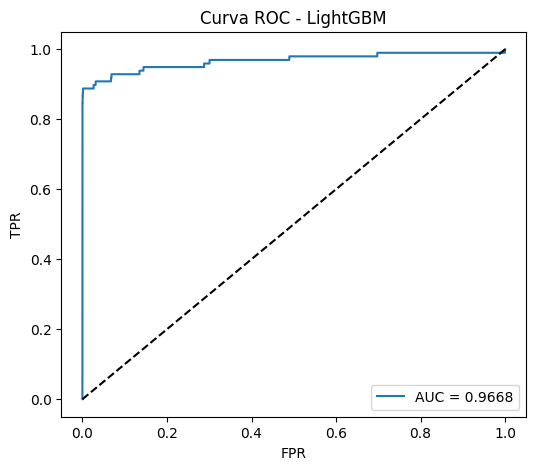

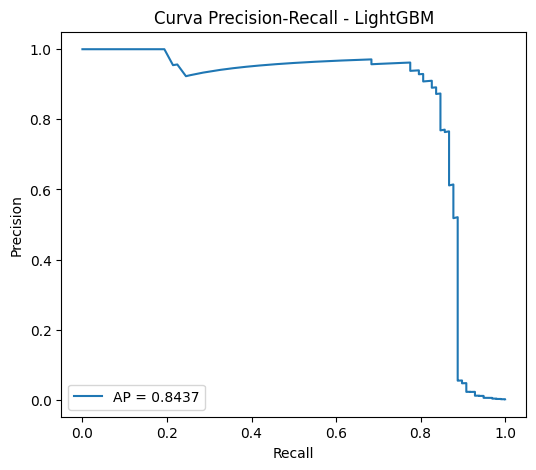

Acurácia: 0.9984
Relatório de Classificação:
              precision    recall  f1-score   support

           0       1.00      1.00      1.00     56864
           1       0.53      0.88      0.66        98

    accuracy                           1.00     56962
   macro avg       0.76      0.94      0.83     56962
weighted avg       1.00      1.00      1.00     56962



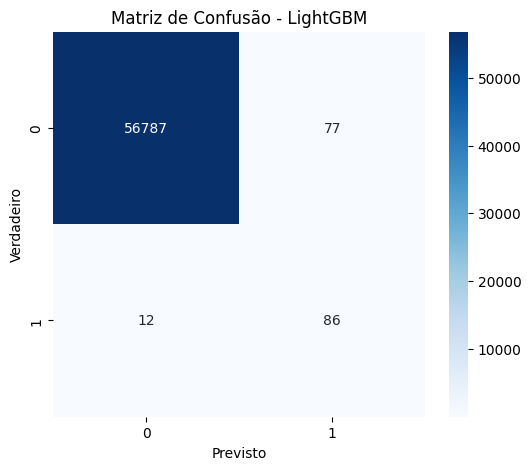

In [9]:
from sklearn.metrics import roc_auc_score, roc_curve, precision_recall_curve, average_precision_score

# Dicionário para armazenar os modelos
models = {
    "Regressão Logística": LogisticRegression(),
    # "Random Forest": RandomForestClassifier(random_state=42), # Desconsiderando Random Forest pelo tamanho do dataset
    "XGBoost": XGBClassifier(random_state=42, use_label_encoder=False, eval_metric='logloss'),
    "LightGBM": LGBMClassifier(random_state=42)
}

# Loop para treinar e avaliar cada modelo
for name, model in models.items():
    print(f"--- Treinando e Avaliando: {name} ---")
    
    # Treinamento com dados SMOTE
    model.fit(X_train_smote, y_train_smote)

    # Métricas threshold-free: ROC e Precision-Recall
    if hasattr(model, "predict_proba"):
        y_scores = model.predict_proba(X_test)[:, 1]
    else:
        y_scores = model.decision_function(X_test)


    roc_auc = roc_auc_score(y_test, y_scores)
    avg_precision = average_precision_score(y_test, y_scores)

    # Curva ROC
    fpr, tpr, _ = roc_curve(y_test, y_scores)
    plt.figure(figsize=(6, 5))
    plt.plot(fpr, tpr, label=f'AUC = {roc_auc:.4f}')
    plt.plot([0, 1], [0, 1], 'k--')
    plt.xlabel('FPR')
    plt.ylabel('TPR')
    plt.title(f'Curva ROC - {name}')
    plt.legend()
    plt.show()

    # Curva Precision-Recall
    precision, recall, _ = precision_recall_curve(y_test, y_scores)
    plt.figure(figsize=(6, 5))
    plt.plot(recall, precision, label=f'AP = {avg_precision:.4f}')
    plt.xlabel('Recall')
    plt.ylabel('Precision')
    plt.title(f'Curva Precision-Recall - {name}')
    plt.legend()
    plt.show()
    
    # Previsões no conjunto de teste original
    predictions = model.predict(X_test)
    
    # Avaliação
    print('Acurácia: {:.4f}'.format(accuracy_score(y_test, predictions)))
    print('Relatório de Classificação:')
    print(classification_report(y_test, predictions))
    
    # Matriz de Confusão
    plt.figure(figsize=(6, 5))
    cm = confusion_matrix(y_test, predictions)
    sns.heatmap(cm, annot=True, fmt='d', cmap='Blues')
    plt.title(f'Matriz de Confusão - {name}')
    plt.ylabel('Verdadeiro')
    plt.xlabel('Previsto')
    plt.show()
    print('' + '='*60 + '')

## 7. Análise dos Resultados e Conclusão

### Análise dos Resultados

- **Recall:** Todos os modelos apresentaram um **recall** muito alto para a classe de fraude (1), o que é o nosso principal objetivo. Isso significa que eles são excelentes em identificar as transações fraudulentas reais. O LightGBM e o XGBoost se destacaram ligeiramente nesse quesito.
- **Precisão:** A precisão para a classe de fraude, no entanto, varia consideravelmente. A Regressão Logística teve a precisão mais baixa, gerando um número muito alto de falsos positivos (transações normais classificadas como fraude). O Random Forest, XGBoost e LightGBM mostraram uma precisão muito superior, com o LightGBM apresentando o melhor equilíbrio.
- **Equilíbrio (Trade-off):** Modelos como LightGBM e XGBoost ofereceram o melhor equilíbrio entre encontrar o máximo de fraudes (alto recall) e não classificar incorretamente muitas transações normais (maior precisão). Embora o recall da Regressão Logística seja alto, sua baixa precisão a torna impraticável para um cenário real, pois causaria muitos transtornos para os clientes.

### Conclusão

Neste notebook, comparamos quatro modelos diferentes para a detecção de fraudes. A técnica de **SMOTE** permitiu que todos os modelos aprendessem os padrões das fraudes de forma eficaz, resultando em um alto recall.

**O LightGBM e o XGBoost foram os modelos com melhor desempenho geral**, oferecendo um excelente recall com uma precisão significativamente melhor que a Regressão Logística. O Random Forest também foi uma opção forte e muito superior ao modelo base.

Para um sistema de produção, o **LightGBM** seria a escolha recomendada entre os modelos testados, devido ao seu bom equilíbrio entre a detecção de fraudes e a minimização de falsos positivos.